In [1]:
!pip uninstall scipy --yes

Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1


In [2]:
!pip install scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 33.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.1 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.4 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.


In [3]:
!pip install kaggle torch torchvision tensorboard tqdm


In [4]:
import os
import numpy as np
import random
import itertools
import time
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from tqdm import tqdm  # For progress bars
from pathlib import Path

# TensorBoard for monitoring training progress
from torch.utils.tensorboard import SummaryWriter


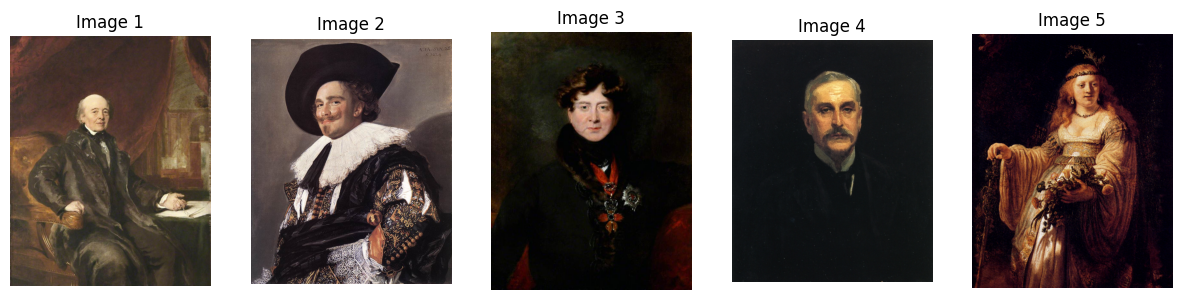

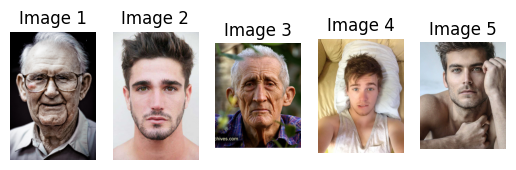

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the directory containing images
art_image_dir = "/kaggle/input/art-portraits/Portraits/Portraits"  # Change this to your dataset path
real_image_dir = "/kaggle/input/human-faces/Humans"
# Get a list of image files
art_image_files = sorted([f for f in os.listdir(art_image_dir) if f.lower().endswith('.jpg')])
real_image_files = sorted([f for f in os.listdir(real_image_dir) if f.lower().endswith('.jpg')])
# Display the first 5 images
plt.figure(figsize=(15, 5))
for i, file in enumerate(art_image_files[:5]):
    img = Image.open(os.path.join(art_image_dir, file))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.show()

for i, file in enumerate(real_image_files[:5]):
    img = Image.open(os.path.join(real_image_dir, file))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.show()

In [6]:
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class TopCenterCrop:
    """ Custom transform to crop the upper-center region of an image with more zoom """
    def __init__(self, crop_height=256, crop_width=256, top_shift=0.1):
        self.crop_height = crop_height
        self.crop_width = crop_width
        self.top_shift = top_shift  # Adjust how high we crop

    def __call__(self, img):
        width, height = img.size  # Get original size

        # Define crop coordinates (move crop higher)
        left = (width - self.crop_width) // 2
        top = int((height - self.crop_height) * self.top_shift)  # Shift crop higher
        right = left + self.crop_width
        bottom = top + self.crop_height

        return img.crop((left, top, right, bottom))

class ImageDataset(Dataset):
    def __init__(self, real_root, art_root, real_transforms=None, art_transforms=None):
        self.real_transform = transforms.Compose(real_transforms) if real_transforms else None
        self.art_transform = transforms.Compose(art_transforms) if art_transforms else None
        
        # Load image file names
        self.real_images = sorted([os.path.join(real_root, f) for f in os.listdir(real_root) if f.endswith(('jpg'))])
        self.art_images = sorted([os.path.join(art_root, f) for f in os.listdir(art_root) if f.endswith(('jpg'))])

    def __getitem__(self, index):
        img_real = Image.open(self.real_images[index % len(self.real_images)]).convert("RGB")
        img_art = Image.open(self.art_images[index % len(self.art_images)]).convert("RGB")

        # Apply transforms
        if self.real_transform:
            img_real = self.real_transform(img_real)
        if self.art_transform:
            img_art = self.art_transform(img_art)

        return {"real": img_real, "art": img_art}

    def __len__(self):
        return max(len(self.real_images), len(self.art_images))

# Define transformations separately
real_transform_list = [
    transforms.Resize((256, 256)),  # Force all real images to be exactly 256x256
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

art_transform_list = [
    transforms.Resize((350, 256)),  # Resize art images to a taller height for better cropping
    TopCenterCrop(256, 256, top_shift=0.1),  # Crop further up to focus more on the face
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]



# Set dataset paths
real_images_path = "/kaggle/input/human-faces/Humans"
art_images_path = "/kaggle/input/art-portraits/Portraits/Portraits"

# Create dataset and dataloader
dataset = ImageDataset(real_root=real_images_path, art_root=art_images_path, 
                       real_transforms=real_transform_list, art_transforms=art_transform_list)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check the dataset size
print(f"Loaded {len(dataset)} image pairs.")


Loaded 6973 image pairs.


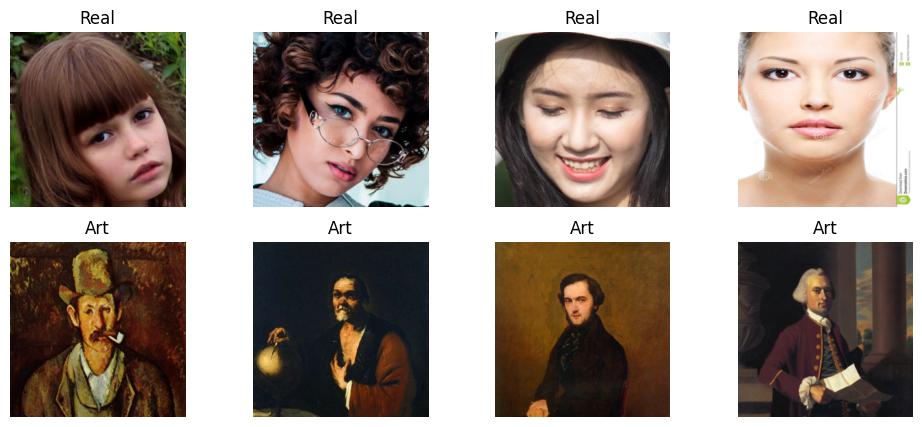

In [7]:
import matplotlib.pyplot as plt

# Function to visualize images
def show_images(dataloader, num_images=4):
    batch = next(iter(dataloader))  # Get one batch
    real_images = batch["real"][:num_images]  # Take first 'num_images' real images
    art_images = batch["art"][:num_images]  # Take first 'num_images' art images

    plt.figure(figsize=(12, 5))
    for i in range(num_images):
        # Display Real Image
        plt.subplot(2, num_images, i + 1)
        plt.imshow((real_images[i].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5)  # Denormalize
        plt.axis("off")
        plt.title("Real")

        # Display Art Image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow((art_images[i].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5)  # Denormalize
        plt.axis("off")
        plt.title("Art")

    plt.show()

# Call the function to visualize
show_images(dataloader)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """ Residual Block for the Generator """
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    """ ResNet-based Generator """
    def __init__(self, in_channels=3, out_channels=3, num_residuals=9):
        super(Generator, self).__init__()
        
        # Initial Convolution Block
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Downsampling
        self.downsampling = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Residual Blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(num_residuals)])
        
        # Upsampling
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Output Layer
        self.output = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.initial(x)
        x = self.downsampling(x)
        x = self.res_blocks(x)
        x = self.upsampling(x)
        return self.output(x)

class Discriminator(nn.Module):
    """ PatchGAN Discriminator """
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_filters, out_filters, stride):
            return nn.Sequential(
                nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=stride, padding=1, bias=False),
                nn.InstanceNorm2d(out_filters) if out_filters != 64 else nn.Identity(),
                nn.LeakyReLU(0.2, inplace=True)
            )
        
        self.model = nn.Sequential(
            discriminator_block(in_channels, 64, stride=2),
            discriminator_block(64, 128, stride=2),
            discriminator_block(128, 256, stride=2),
            discriminator_block(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )
        
    def forward(self, x):
        return self.model(x)


Epoch [0/1] Batch [0/1744] Loss G: 19.5741 Loss D_A: 0.9321 Loss D_B: 1.1309
Epoch [0/1] Batch [1/1744] Loss G: 21.5757 Loss D_A: 6.9862 Loss D_B: 5.7215
Epoch [0/1] Batch [2/1744] Loss G: 15.4853 Loss D_A: 1.9697 Loss D_B: 2.7986
Epoch [0/1] Batch [3/1744] Loss G: 14.0608 Loss D_A: 0.9131 Loss D_B: 1.6300
Epoch [0/1] Batch [4/1744] Loss G: 12.8727 Loss D_A: 1.2537 Loss D_B: 1.0588
Epoch [0/1] Batch [5/1744] Loss G: 10.5982 Loss D_A: 1.4791 Loss D_B: 0.6437
Epoch [0/1] Batch [6/1744] Loss G: 13.0569 Loss D_A: 0.8745 Loss D_B: 0.6821
Epoch [0/1] Batch [7/1744] Loss G: 12.1422 Loss D_A: 0.6594 Loss D_B: 0.7986
Epoch [0/1] Batch [8/1744] Loss G: 10.2936 Loss D_A: 0.6009 Loss D_B: 0.9665
Epoch [0/1] Batch [9/1744] Loss G: 9.6136 Loss D_A: 0.5861 Loss D_B: 0.9444
Epoch [0/1] Batch [10/1744] Loss G: 11.0519 Loss D_A: 0.5979 Loss D_B: 0.6560
Epoch [0/1] Batch [11/1744] Loss G: 9.0769 Loss D_A: 0.5346 Loss D_B: 0.5977
Epoch [0/1] Batch [12/1744] Loss G: 8.6666 Loss D_A: 0.5319 Loss D_B: 0.5590

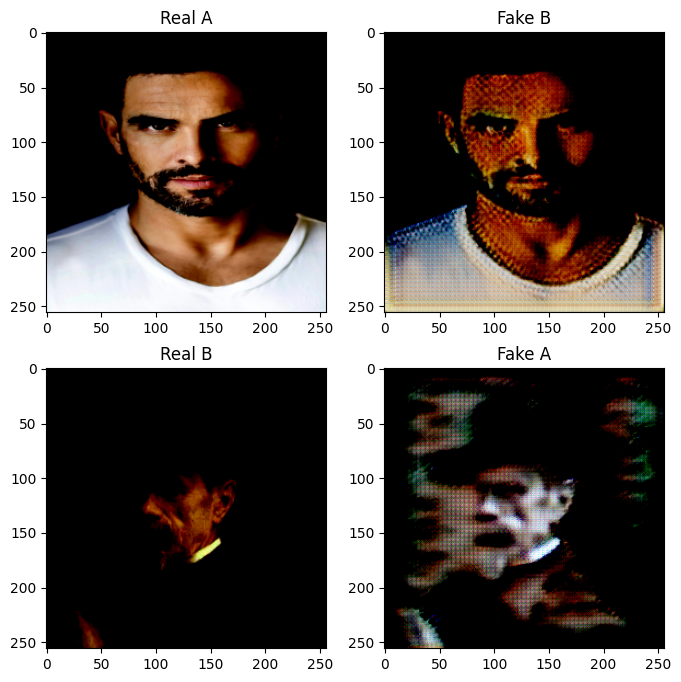

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import matplotlib.pyplot as plt

def visualize_sample(epoch, real_A, fake_B, real_B, fake_A):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs[0, 0].imshow(real_A[0].permute(1, 2, 0).cpu().detach().numpy())
    axs[0, 0].set_title("Real A")
    axs[0, 1].imshow(fake_B[0].permute(1, 2, 0).cpu().detach().numpy())
    axs[0, 1].set_title("Fake B")
    axs[1, 0].imshow(real_B[0].permute(1, 2, 0).cpu().detach().numpy())
    axs[1, 0].set_title("Real B")
    axs[1, 1].imshow(fake_A[0].permute(1, 2, 0).cpu().detach().numpy())
    axs[1, 1].set_title("Fake A")
    plt.show()

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_A2B = Generator().to(device)
generator_B2A = Generator().to(device)
discriminator_A = Discriminator().to(device)
discriminator_B = Discriminator().to(device)

# Loss Functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

optimizer_G = torch.optim.Adam(itertools.chain(generator_A2B.parameters(), generator_B2A.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_D_A = torch.optim.Adam(discriminator_A.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_B = torch.optim.Adam(discriminator_B.parameters(), lr=lr, betas=(beta1, beta2))

# Learning Rate Schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / float(100))
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / float(100))
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / float(100))

# Training Loop Setup
def train_cycle_gan(dataloader, epochs, device):
    for epoch in range(epochs):
        for i, batch in enumerate(dataloader):
            real_A = batch["real"].to(device)
            real_B = batch["art"].to(device)
            
            # Train Generators A2B and B2A
            optimizer_G.zero_grad()
            fake_B = generator_A2B(real_A)
            fake_A = generator_B2A(real_B)
            loss_GAN_A2B = criterion_GAN(discriminator_B(fake_B), torch.ones_like(discriminator_B(fake_B)))
            loss_GAN_B2A = criterion_GAN(discriminator_A(fake_A), torch.ones_like(discriminator_A(fake_A)))
            
            # Cycle Consistency Loss
            recov_A = generator_B2A(fake_B)
            recov_B = generator_A2B(fake_A)
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)
            
            # Identity Loss
            loss_identity_A = criterion_identity(generator_B2A(real_A), real_A)
            loss_identity_B = criterion_identity(generator_A2B(real_B), real_B)
            
            loss_G = loss_GAN_A2B + loss_GAN_B2A + 10.0 * (loss_cycle_A + loss_cycle_B) + 5.0 * (loss_identity_A + loss_identity_B)
            loss_G.backward()
            optimizer_G.step()
            
            # Train Discriminators
            optimizer_D_A.zero_grad()
            loss_D_A = criterion_GAN(discriminator_A(real_A), torch.ones_like(discriminator_A(real_A))) + criterion_GAN(discriminator_A(fake_A.detach()), torch.zeros_like(discriminator_A(fake_A)))
            loss_D_A.backward()
            optimizer_D_A.step()
            
            optimizer_D_B.zero_grad()
            loss_D_B = criterion_GAN(discriminator_B(real_B), torch.ones_like(discriminator_B(real_B))) + criterion_GAN(discriminator_B(fake_B.detach()), torch.zeros_like(discriminator_B(fake_B)))
            loss_D_B.backward()
            optimizer_D_B.step()
            
            print(f"Epoch [{epoch}/{epochs}] Batch [{i}/{len(dataloader)}] Loss G: {loss_G.item():.4f} Loss D_A: {loss_D_A.item():.4f} Loss D_B: {loss_D_B.item():.4f}")
        
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()
        
        if epoch % 10 == 0:
            visualize_sample(epoch, real_A, fake_B, real_B, fake_A)
            
# Start Training
epochs = 1
train_cycle_gan(dataloader, epochs, device)


In [13]:
torch.save(generator_A2B.state_dict(), "generator_A2B.pth")
torch.save(generator_B2A.state_dict(), "generator_B2A.pth")


In [14]:
def load_checkpoint(generator, checkpoint_path):
    generator.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    generator.eval()

def test_generator(generator, image_path, device):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        fake_image = generator(image)
    
    fake_image = (fake_image.squeeze(0).permute(1, 2, 0).cpu().numpy() + 1) / 2
    plt.imshow(fake_image)
    plt.axis("off")
    plt.show()

<ipython-input-19-7fdf7280bb1e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_A2B.load_state_dict(torch.load("generator_A2B.pth", map_location=device))


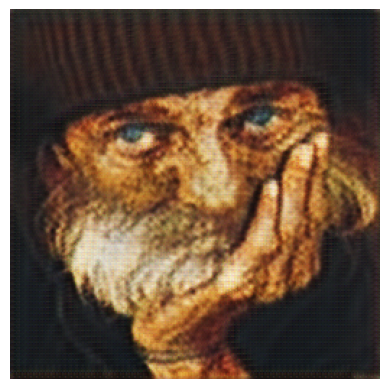

In [19]:
# Load the saved generator
generator_A2B.load_state_dict(torch.load("generator_A2B.pth", map_location=device))
generator_A2B.eval()  # Set to evaluation mode

# Test the generator on an input image
test_generator(generator_A2B, "/kaggle/input/human-faces/Humans/1 (1013).jpg", device)


<ipython-input-22-5cd15ec4bf4c>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


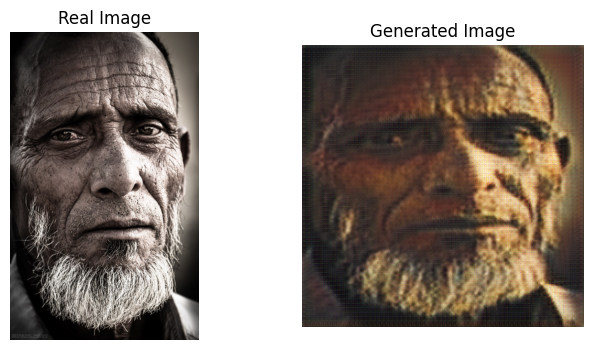

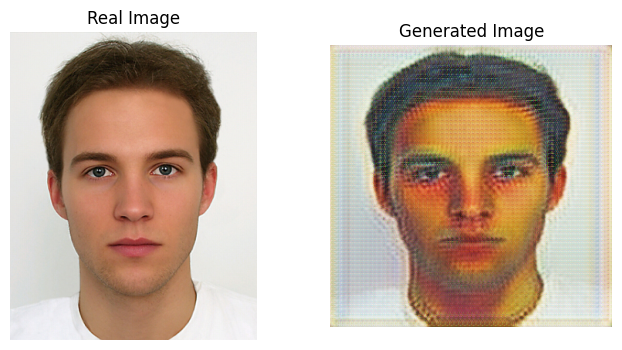

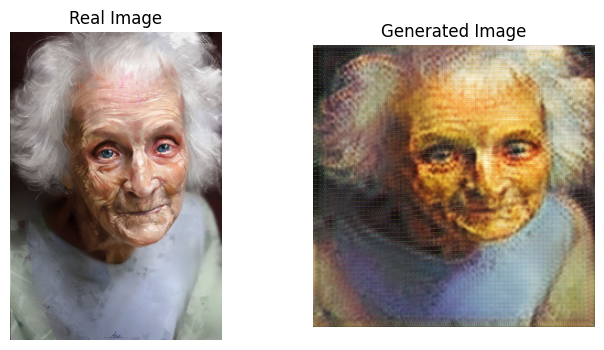

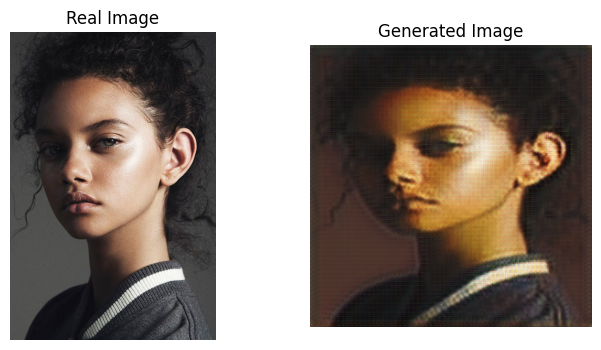

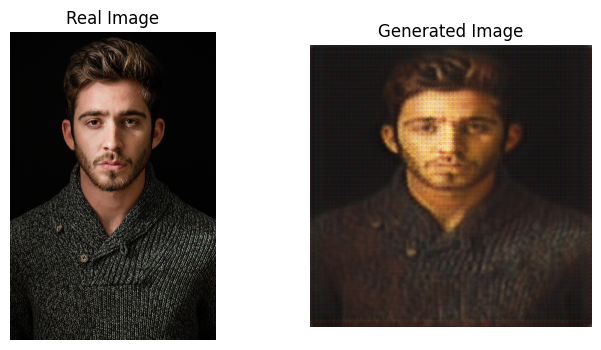

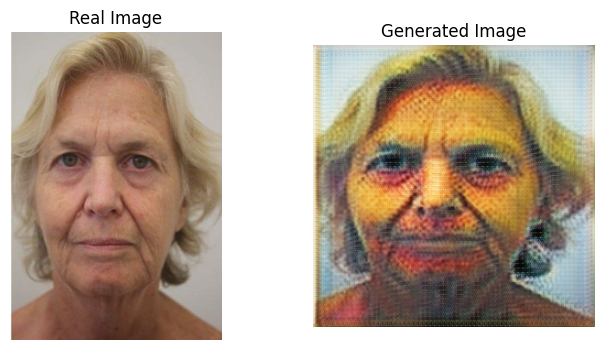

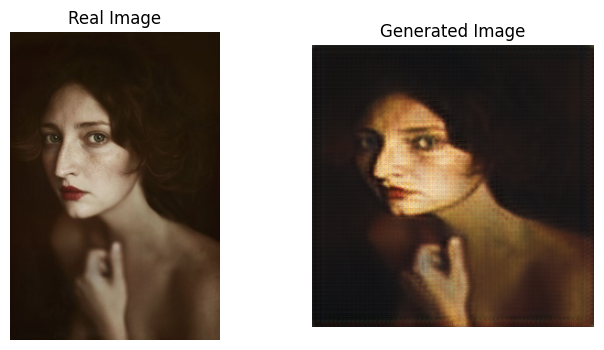

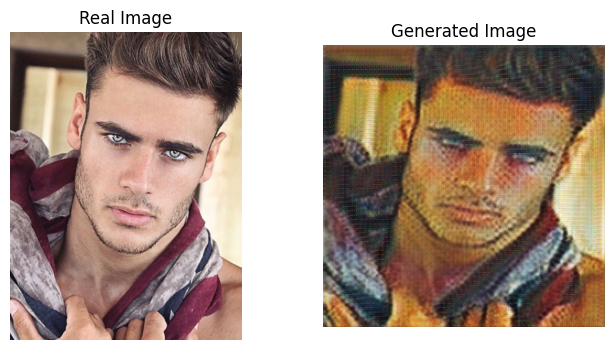

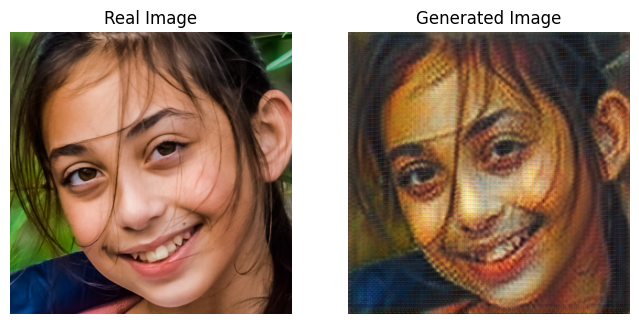

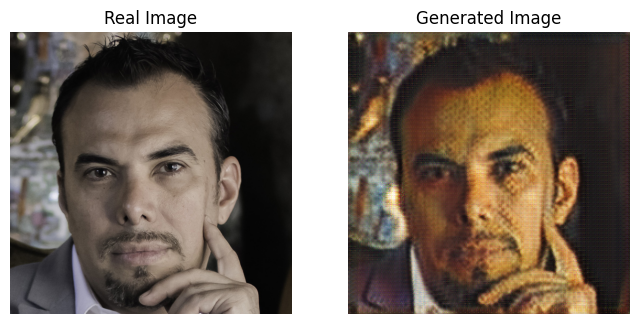

In [22]:
import os
import random
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load the trained model
def load_generator(model, checkpoint_path, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    return model

# Function to generate and display results
def test_generator_on_multiple_images(generator, image_dir, device, num_images=10):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Get random images from the directory
    image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith((".jpg", ".png"))]
    selected_images = random.sample(image_paths, min(num_images, len(image_paths)))

    for img_path in selected_images:
        image = Image.open(img_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Generate fake image
        with torch.no_grad():
            fake_image = generator(image_tensor)

        # Convert back to image
        fake_image = (fake_image.squeeze(0).permute(1, 2, 0).cpu().numpy() + 1) / 2

        # Display results
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(image)
        axs[0].set_title("Real Image")
        axs[0].axis("off")
        axs[1].imshow(fake_image)
        axs[1].set_title("Generated Image")
        axs[1].axis("off")
        plt.show()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load generator model
generator_A2B = Generator().to(device)
generator_A2B = load_generator(generator_A2B, "generator_A2B.pth", device)

# Set test image directory and run test
test_image_directory = "/kaggle/input/human-faces/Humans"
test_generator_on_multiple_images(generator_A2B, test_image_directory, device)
